In [1]:
!nvidia-smi

Wed Sep 16 15:19:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.88       Driver Version: 418.88       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:19:00.0 Off |                  Off |
| 33%   31C    P8    21W / 260W |   1112MiB / 48571MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   32C    P8    16W / 260W |      1MiB / 48571MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  Q

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import torch.nn as nn
import datetime
import time
%matplotlib notebook
from IPython.core.debugger import set_trace
from torch_geometric.data import Data, Dataset, InMemoryDataset, DataLoader
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d
from torch_geometric.nn import GCNConv
import pyvista as pv
from threading import Thread
import vtk
from IPython.display import HTML, display
from pyvirtualdisplay import Display
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
np.random.seed(0)
torch.manual_seed(0)
pv.set_plot_theme("document")

In [4]:
def load_simulation_input(simulation_id, simulation_result_path = '/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results'):
    edge_index_list = []
    pos_list = []
    elements = []
    birth_list_element = []
    birth_list_node = []
    with open('{}/{}/gamma/{}.k'.format(simulation_result_path, simulation_id, simulation_id)) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*NODE':
                first = True
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    if first:
                        node_base = int(text[0])
                        first = False
                    pos_list.append([float(text[1]),float(text[2]),float(text[3])])
            if line.split()[0] == '*END':
                break  
    birth_list_node = [-1 for _ in range(len(pos_list))]
    with open('{}/{}/gamma/{}.k'.format(simulation_result_path, simulation_id, simulation_id)) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*ELEMENT_SOLID':
                first = True
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    if first:
                        element_base = int(text[0])
                        first = False
                    elements.append([int(text[2])-node_base, int(text[3])-node_base, int(text[4])-node_base, int(text[5])-node_base,
                                     int(text[6])-node_base, int(text[7])-node_base, int(text[8])-node_base, int(text[9])-node_base])
                    for source_ind in range(2, 10):
                        for taget_ind in range(2, 10):
                            if source_ind == taget_ind:
                                continue
                            edge_index_list.append([int(text[source_ind])-node_base, int(text[taget_ind])-node_base])
            if line.split()[0] == '*END':
                break
    birth_list_element = [-1.0]*len(elements)
    with open('{}/{}/gamma/{}.k'.format(simulation_result_path, simulation_id, simulation_id)) as f:
        while True:
            line = next(f)
            if not line.split():
                continue
            if line.split()[0] == '*DEFINE_CURVE':
                while True:
                    line = next(f)
                    if line[0] == '*':
                        break
                    if line[0] == '$':
                        continue
                    text = line.split()
                    birth_list_element[int(float(text[1]))-element_base] = float(text[0])
            if line.split()[0] == '*END':
                break     
    
    for element, birth_element in zip(elements, birth_list_element):
        if birth_element < 0:
            continue
        for node in element:
            if (birth_list_node[node] > birth_element or 
                                        birth_list_node[node] < 0):
                                    birth_list_node[node] = birth_element

    edge_index = torch.tensor(edge_index_list ,dtype=torch.long)
    elements = torch.tensor(elements ,dtype=torch.long)
    pos = torch.tensor(pos_list ,dtype=torch.float)
    birth_element = torch.tensor(birth_list_element, dtype=torch.float)
    birth_node = torch.tensor(birth_list_node, dtype=torch.float)
    return edge_index, elements, pos, birth_element, birth_node

def load_toolpath(simulation_id, simulation_result_path = '/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results', dt = 0.1):
    file = '{}/{}/gamma/toolpath.crs'.format(simulation_result_path, simulation_id)
    toolpath_raw=pd.read_table(file, delimiter=r"\s+",header=None, names=['time','x','y','z','state'])
    toolpath=[]
    state=[]
    time=0.0
    ind=0
    endTime = float(toolpath_raw.tail(1)['time'])
    while(time<=endTime):
        while(time>=toolpath_raw['time'][ind+1]):
            ind=ind+1
        X=toolpath_raw['x'][ind]+(toolpath_raw['x'][ind+1]-toolpath_raw['x'][ind])*(
            time-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Y=toolpath_raw['y'][ind]+(toolpath_raw['y'][ind+1]-toolpath_raw['y'][ind])*(
            time-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        Z=toolpath_raw['z'][ind]+(toolpath_raw['z'][ind+1]-toolpath_raw['z'][ind])*(
            time-toolpath_raw['time'][ind])/(toolpath_raw['time'][ind+1]-toolpath_raw['time'][ind])
        toolpath.append([X,Y,Z])
        state.append(toolpath_raw['state'][ind+1])
        time = time +dt
    return toolpath, state, endTime

def load_simulation_output(simulation_id, simulation_result_path = '/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results'):
    temperature = pd.read_csv('{}/{}/gamma/{}.csv'.format(simulation_result_path, simulation_id, simulation_id))
    temperature.drop(temperature.columns[len(temperature.columns)-1], axis=1, inplace=True)
    return torch.tensor(temperature.values, dtype=torch.float)

In [5]:
class AdditiveThermalDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, normalize=True):
        self.seq_len = 100 # length of each sample
        self.sample_per_simulation = 100 # number of samples in each simulation
        # self.simulation_ids = ['17', '18', '19'] # for testing
        self.simulation_ids = [x.stem for x in Path('/home/mmv664/Documents/Graph_modeling/AutoGAMMA/2_simulation_results').iterdir() if x.is_dir()]
        self.normalize = normalize
        if normalize:
            self.stats = torch.load("/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling/processed/stats")
        super(AdditiveThermalDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['am_graph.simul0.data0']

    def download(self):
        pass
    
    def process(self):
        
        i = 0 # simulation_idx
        for simulation_id in self.simulation_ids:
            print("processing simulation {}!".format(simulation_id))
            j = 0 # time_idx
        
            # load simulation settings
            edge_index, elements, pos, birth_element, birth = load_simulation_input(simulation_id)
            toolpath, state, endTime = load_toolpath(simulation_id)
            
            # temperature output
            temperature = load_simulation_output(simulation_id)
            temperature = torch.clamp(temperature, 300.0, 2000.0)

            # edge feature (length of each edge)
            edge_pos = pos[edge_index.long()]
            edge_dis = ((edge_pos[:, 0, :] - edge_pos[:, 1, :])**2).sum(dim = 1)
            
            # boundary feature (distance to fixed boundary condition at z = -20)
            boundary = pos[:, 2] + 20.0

            assert (temperature.shape[1] == pos.shape[0])

            seed = np.random.permutation(temperature.shape[0]-self.seq_len)[0:self.sample_per_simulation] # the starting time of each sample 
            torch.save(seed, osp.join(self.processed_dir, 'simul{}.seed'.format(i)))
            j = 0
            for start_time in seed:
                x_data = torch.Tensor([])
                y_data = torch.Tensor([])
                birth_data = torch.Tensor([])
                for time_step in range(start_time, start_time + self.seq_len):
                    toolpath_current_step = toolpath[time_step]
                    state_current_step = state[time_step]   
                    r2 = (pos[:, 0] - toolpath_current_step[0])**2 + (pos[:, 1] - toolpath_current_step[1])**2 + (pos[:, 2] - toolpath_current_step[2])**2 + 0.1
                    if state_current_step == 1:
                        laser_feature = 1/r2
                    else:
                        laser_feature = r2 * 0.0                   

                    temp_time_step = temperature[time_step, :]
                    # temp_time_step_next = temperature[time_step + 1, :]

                    birth_time_step = (birth < time_step * 0.1).float()
                    # birth_time_step_next = (birth < (time_step + 1) * 0.1).float()

                    birth_time_element = (birth_element < time_step * 0.1).float()

                    x = torch.cat([
                    #              temp_time_step.unsqueeze(1),
                                   birth_time_step.unsqueeze(1),
                                   boundary.unsqueeze(1),
                                   laser_feature.unsqueeze(1)], dim = 1)
                    y = torch.cat([temp_time_step.unsqueeze(1),
                    #              temp_time_step_next.unsqueeze(1),
                    #              birth_time_step_next.unsqueeze(1)
                                  ], dim = 1)

                    x_data = torch.cat((x_data, x.unsqueeze(0)),0)
                    y_data = torch.cat((y_data, y.unsqueeze(0)),0)
                    birth_data = torch.cat((birth_data, birth_time_element.unsqueeze(0)),0)

                data = Data(x=x_data, y=y_data, birth_element=birth_data)
                torch.save(data, osp.join(self.processed_dir, 'am_graph.simul{}.data{}'.format(i,j)))

                j = j + 1
                if j%40 == 0:
                    print("{:.2f} %".format(j/2))

            const_data = Data(pos = pos, edge_index=edge_index.t().contiguous(), edge_attr = edge_dis, elements=elements)
            torch.save(const_data, osp.join(self.processed_dir, 'am_graph.simul{}.const'.format(i)))
            i += 1
            
    def len(self):
        return self.sample_per_simulation * len(self.simulation_ids)

    def get(self, idx):
        i = idx//self.sample_per_simulation
        j = idx%self.sample_per_simulation
        constant_data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.const'.format(i)))
        data = torch.load(osp.join(self.processed_dir, 'am_graph.simul{}.data{}'.format(i,j)))
        data_x = data['x']
        data_e = constant_data['edge_attr']
        data_y = data['y']
        if self.normalize:
            # normalize boundary feature to the range of 0-1
            data_x[:,:,1] = (data_x[:,:,1] - self.stats[1,2]) / (self.stats[1,3] - self.stats[1,2])
            # normalize laser feature to mean of zeros and std of 1
            data_x[:,:,2] = (data_x[:,:,2] - self.stats[2,2]) / (self.stats[2,3] - self.stats[2,2])
            # nomalize edge feature to mean of zero and std of 1
            data_e = 1.0/data_e**0.5
            # normalize temperature to the range of 0-1
            data_y = (data_y - self.stats[3,2]) / (self.stats[3,3] - self.stats[3,2])
            
        return Data(
                    x=data_x.transpose(0,1), 
                    y=data_y.transpose(0,1), 
                    pos=constant_data['pos'], 
                    edge_index=constant_data['edge_index'],
                    edge_attr = data_e,
                    birth_element=data['birth_element'].transpose(0,1),
                    elements=constant_data['elements']
                   )

In [6]:
dataset = AdditiveThermalDataset('/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling', normalize=True)

In [7]:
dataset = dataset.shuffle()
dataset = dataset[0:450]
one_tenth_length = int(len(dataset) * 0.1)
train_dataset = dataset[:one_tenth_length * 8]
test_dataset = dataset[one_tenth_length*8:]
len(train_dataset), len(test_dataset)

(360, 90)

In [8]:
dataset[0]

Data(birth_element=[19761, 100], edge_attr=[1106616], edge_index=[2, 1106616], elements=[19761, 8], pos=[23636, 3], x=[23636, 100, 3], y=[23636, 100, 1])

In [9]:
batch_size= 1
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size)
visualization_loader = DataLoader(train_dataset, batch_size=1)

In [10]:
# # only run for the first time when building the stats, other times stats can be just loaded from AdditiveThermalDataset

# sums, squared_sums, num_sample, min_, max_ = torch.zeros(4), torch.zeros(4), torch.zeros(4), torch.ones(4) * 1e10, torch.ones(4) * -1e10
# sums_e, squared_sums_e, num_sample_e, min_e, max_e = torch.zeros(1), torch.zeros(1), torch.zeros(1), torch.ones(1) * 1e10, torch.ones(1) * -1e10

# for data in train_dataset:
#     data_xy = torch.cat((data.x, data.y), 2)
#     data_e = data.edge_attr
#     sums += torch.sum(data_xy, dim=[0,1])
#     sums_e += torch.sum(data_e, dim=[0])
#     squared_sums += torch.sum(data_xy**2, dim=[0, 1])
#     squared_sums_e += torch.sum(data_e**2, dim=[0])
#     num_sample += data_xy.shape[0] * data_xy.shape[1]
#     num_sample_e += data_e.shape[0]
#     min_ = torch.min(min_, data_xy.view(-1,data_xy.shape[-1]).min(dim=0).values)
#     max_ = torch.max(max_, data_xy.view(-1,data_xy.shape[-1]).max(dim=0).values)
#     min_e = torch.min(min_e, data_e.min(dim=0).values)
#     max_e = torch.max(max_e, data_e.max(dim=0).values)    

# mean = sums/num_sample
# std = (squared_sums/num_sample - mean**2)**0.5
# mean_e = sums_e/num_sample_e
# std_e = (squared_sums_e/num_sample_e - mean_e**2)**0.5

# stats_xy = torch.cat((mean.unsqueeze(1),
#                   std.unsqueeze(1), 
#                   min_.unsqueeze(1),
#                   max_.unsqueeze(1)),
#                   1)
# stats_e = torch.cat((mean_e, std_e, min_e, max_e)).unsqueeze(0)
# stats = torch.cat((stats_xy, stats_e), 0)
# torch.save(stats, "processed/stats")

In [27]:
test = torch.ones((3,3,2))

In [21]:
conv1 = GCNConv(3, 10)

In [ ]:
gru2()

In [22]:
dim = 16
input_features = 3
dropout = 0.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(input_features, dim)
        self.conv2 = GCNConv(dim, dim)
        self.conv3 = GCNConv(dim, dim)
        self.conv4 = GCNConv(dim, dim)
        self.conv5 = GCNConv(dim, dim)
        self.gru1 = torch.nn.GRU(dim, dim, num_layers=3)
        self.gru2 = torch.nn.GRU(dim, 1)
        
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)
        self.norm4 = nn.LayerNorm(dim)
        self.norm5 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)


    def forward(self, data):
        X, Y, edge_index, edge_weight = data.x, data.y, data.edge_index, data.edge_attr
        print(X.shape)
        # extract features from time sequence 
        for i in range(1,X.shape[1]):
            x = X[:,i,:]
            feature = self.dropout(self.norm1(F.relu(self.conv1(x, edge_index, edge_weight))))
            feature = self.dropout(self.norm2(F.relu(self.conv2(feature, edge_index, edge_weight)) + feature))
            feature = self.dropout(self.norm3(F.relu(self.conv3(feature, edge_index, edge_weight)) + feature))
            feature = self.dropout(self.norm4(F.relu(self.conv4(feature, edge_index, edge_weight)) + feature))
            feature = self.dropout(self.norm5(F.relu(self.conv5(feature, edge_index, edge_weight)) + feature))

            if i == 1:
                features = feature.unsqueeze(0)
            else:
                features = torch.cat((features, feature.unsqueeze(0)),0)
        
# #         x_exclude_first = X[:,1:,:]
#         x_2 = x_exclude_first.reshape(x_exclude_first.shape[0]*x_exclude_first.shape[1], x_exclude_first.shape[2])
#         feature_2 = self.dropout(self.norm1(F.relu(self.conv1(x_2, edge_index, edge_weight))))
#         feature_2 = self.dropout(self.norm2(F.relu(self.conv2(feature_2, edge_index, edge_weight)) + feature_2))
#         feature_2 = self.dropout(self.norm3(F.relu(self.conv3(feature_2, edge_index, edge_weight)) + feature_2))
#         feature_2 = self.dropout(self.norm4(F.relu(self.conv4(feature_2, edge_index, edge_weight)) + feature_2))
#         feature_2 = self.dropout(self.norm5(F.relu(self.conv5(feature_2, edge_index, edge_weight)) + feature_2))
#         features_2 = feature_2.reshape(x_exclude_first.shape[1], x_exclude_first.shape[0], dim)

        # initial state: node birth info
        h_0 = X[:,0,0].reshape(1,-1,1).repeat([3,1,16]).contiguous()
        out,h = self.gru1(features,h_0)
        
        # initial state: temp
        h_0 = Y[:,0,:].unsqueeze(0).contiguous()
        out,h = self.gru2(out,h_0)
        
        return out
#         return features, features_2

In [37]:
logdir='results/{}'.format(datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S"))
description = "smaller data_no edge weight_no dropout"

os.makedirs(logdir, exist_ok=True)
writer = SummaryWriter(logdir)
writer.add_text("Description", description)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [24]:
for data in train_loader:
    data = data.to(device)
    predict = model(data)
    break

torch.Size([34990, 100, 3])


In [18]:
predict[0].shape

torch.Size([99, 20650, 16])

In [20]:
predict[1]

tensor([[[-0.5428, -1.0176, -0.3458,  ..., -0.1628,  0.8832, -1.0159],
         [-0.5407, -0.9733, -0.3704,  ..., -0.1041,  0.9760, -0.9974],
         [-0.5361, -0.9676, -0.3667,  ..., -0.0977,  0.9908, -0.9978],
         ...,
         [-0.3560, -1.0985,  0.0642,  ..., -0.5063,  0.7493, -1.3161],
         [-0.4098, -1.0928, -0.1445,  ..., -0.3425,  0.7857, -1.3636],
         [-0.3702, -1.0547, -0.0955,  ..., -0.3422,  0.8577, -1.3454]],

        [[-0.4253, -1.0906, -0.1778,  ..., -0.3177,  0.8217, -1.2445],
         [-0.4253, -1.0906, -0.1778,  ..., -0.3177,  0.8217, -1.2446],
         [-0.4253, -1.0906, -0.1778,  ..., -0.3176,  0.8218, -1.2446],
         ...,
         [-0.9796, -0.1577, -1.0203,  ...,  1.2981,  2.0888,  0.1838],
         [-0.9796, -0.1577, -1.0203,  ...,  1.2981,  2.0888,  0.1838],
         [-0.9796, -0.1577, -1.0203,  ...,  1.2981,  2.0888,  0.1838]],

        [[-0.9796, -0.1577, -1.0203,  ...,  1.2981,  2.0888,  0.1838],
         [-0.9796, -0.1577, -1.0203,  ...,  1

In [19]:
predict[0]

tensor([[[-0.5946, -0.9322, -0.4273,  ...,  0.0124,  1.0196, -0.9588],
         [-0.5763, -0.9143, -0.4139,  ...,  0.0258,  1.0669, -0.9693],
         [-0.5711, -0.9095, -0.4091,  ...,  0.0304,  1.0805, -0.9704],
         ...,
         [-0.8632, -0.3110, -0.8546,  ...,  0.9557,  1.8011, -0.5459],
         [-0.9159, -0.3489, -0.9185,  ...,  0.9056,  1.6751, -0.5182],
         [-0.8447, -0.2934, -0.8273,  ...,  0.9563,  1.8439, -0.5780]],

        [[-0.5946, -0.9322, -0.4273,  ...,  0.0124,  1.0196, -0.9588],
         [-0.5763, -0.9143, -0.4139,  ...,  0.0258,  1.0669, -0.9693],
         [-0.5711, -0.9095, -0.4091,  ...,  0.0304,  1.0805, -0.9704],
         ...,
         [-0.8632, -0.3110, -0.8546,  ...,  0.9557,  1.8011, -0.5459],
         [-0.9159, -0.3489, -0.9185,  ...,  0.9056,  1.6751, -0.5182],
         [-0.8447, -0.2934, -0.8273,  ...,  0.9563,  1.8439, -0.5780]],

        [[-0.5946, -0.9322, -0.4273,  ...,  0.0124,  1.0196, -0.9588],
         [-0.5763, -0.9143, -0.4139,  ...,  0

In [39]:
def train(loader):
    model.train()
    loss_all = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        predict = model(data)
        # mask the node not born 
        output = data.y[:,1:,:].transpose(0,1)
        birth = data.x[:,1:,0].transpose(0,1)
        loss = F.mse_loss(predict[:,:,0]*birth, output[:,:,0]*birth)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / (len(loader) * loader.batch_size)

def test(loader):
    model.eval()
    loss_all = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            predict = model(data)
             # mask the node not born
            output = data.y[:,1:,:].transpose(0,1)
            birth = data.x[:,1:,0].transpose(0,1)
            loss = F.mse_loss(predict[:,:,0]*birth, output[:,:,0]*birth)
            loss_all += data.num_graphs * loss.item()
    return loss_all / (len(loader) * loader.batch_size)

In [ ]:
his = []
# trian_loss = test(train_loader)
# test_loss = test(test_loader)
# his.append([trian_loss, test_loss])
# writer.add_scalar("train_loss", trian_loss, 0)
# writer.add_scalar("test_loss", test_loss, 0)
# print('[{}] Epoch: {:03d}, Train loss: {:.2E}, Test loss: {:.2E} '.format(
#     str(datetime.datetime.now().strftime('%H:%M:%S')), 0, trian_loss,test_loss))
for epoch in range(0, 200):
    trian_loss = train(train_loader)
    test_loss = test(test_loader)
    his.append([trian_loss, test_loss])
    writer.add_scalar("train_loss", trian_loss, epoch)
    writer.add_scalar("test_loss", test_loss, epoch)
    print('[{}] Epoch: {:03d}, Train loss: {:.2E}, Test loss: {:.2E} '.format(
        str(datetime.datetime.now().strftime('%H:%M:%S')), epoch, trian_loss,test_loss))


[13:42:41] Epoch: 000, Train loss: 5.40E-03, Test loss: 2.06E-04 
[13:47:37] Epoch: 001, Train loss: 1.74E-04, Test loss: 1.66E-04 
[13:52:33] Epoch: 002, Train loss: 1.51E-04, Test loss: 1.46E-04 
[13:57:29] Epoch: 003, Train loss: 1.36E-04, Test loss: 1.37E-04 
[14:02:24] Epoch: 004, Train loss: 1.27E-04, Test loss: 1.28E-04 
[14:07:20] Epoch: 005, Train loss: 1.21E-04, Test loss: 1.22E-04 
[14:12:16] Epoch: 006, Train loss: 1.17E-04, Test loss: 1.17E-04 
[14:17:12] Epoch: 007, Train loss: 1.13E-04, Test loss: 1.17E-04 
[14:22:08] Epoch: 008, Train loss: 1.12E-04, Test loss: 1.13E-04 
[14:27:03] Epoch: 009, Train loss: 1.11E-04, Test loss: 1.36E-04 
[14:31:59] Epoch: 010, Train loss: 1.09E-04, Test loss: 1.11E-04 
[14:36:55] Epoch: 011, Train loss: 1.09E-04, Test loss: 1.07E-04 
[14:41:51] Epoch: 012, Train loss: 1.11E-04, Test loss: 1.11E-04 
[14:46:46] Epoch: 013, Train loss: 1.08E-04, Test loss: 1.06E-04 
[14:51:42] Epoch: 014, Train loss: 1.06E-04, Test loss: 1.12E-04 
[14:56:38]

KeyboardInterrupt: 

In [16]:
his = []
# trian_loss = test(train_loader)
# test_loss = test(test_loader)
# his.append([trian_loss, test_loss])
# writer.add_scalar("train_loss", trian_loss, 0)
# writer.add_scalar("test_loss", test_loss, 0)
# print('[{}] Epoch: {:03d}, Train loss: {:.2E}, Test loss: {:.2E} '.format(
#     str(datetime.datetime.now().strftime('%H:%M:%S')), 0, trian_loss,test_loss))
for epoch in range(0, 200):
    trian_loss = train(train_loader)
    test_loss = test(test_loader)
    his.append([trian_loss, test_loss])
    writer.add_scalar("train_loss", trian_loss, epoch)
    writer.add_scalar("test_loss", test_loss, epoch)
    print('[{}] Epoch: {:03d}, Train loss: {:.2E}, Test loss: {:.2E} '.format(
        str(datetime.datetime.now().strftime('%H:%M:%S')), epoch, trian_loss,test_loss))


[09:07:21] Epoch: 000, Train loss: 2.27E-03, Test loss: 2.01E-04 
[09:22:58] Epoch: 001, Train loss: 1.48E-04, Test loss: 1.18E-04 
[09:38:35] Epoch: 002, Train loss: 1.02E-04, Test loss: 1.19E-04 
[09:54:12] Epoch: 003, Train loss: 8.92E-05, Test loss: 8.23E-05 
[10:09:47] Epoch: 004, Train loss: 8.34E-05, Test loss: 7.98E-05 
[10:25:25] Epoch: 005, Train loss: 8.12E-05, Test loss: 7.42E-05 
[10:41:01] Epoch: 006, Train loss: 8.02E-05, Test loss: 7.70E-05 
[10:56:39] Epoch: 007, Train loss: 7.90E-05, Test loss: 7.03E-05 
[11:12:15] Epoch: 008, Train loss: 7.54E-05, Test loss: 6.80E-05 
[11:27:54] Epoch: 009, Train loss: 7.27E-05, Test loss: 7.02E-05 


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


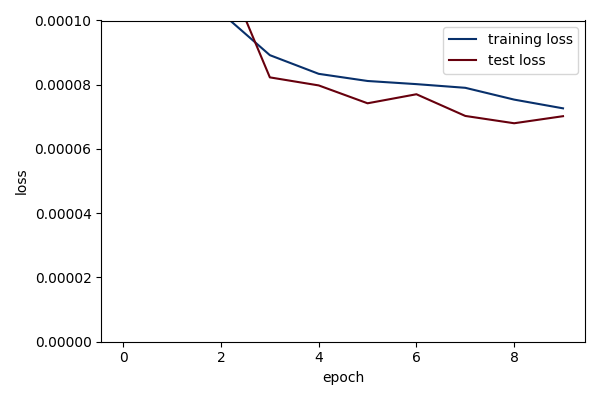

In [17]:
his = np.array(his)
cmap1 = cm.get_cmap('Blues')(np.linspace(1, 0.5, 3))
cmap2 = cm.get_cmap('Reds')(np.linspace(1, 0.5, 3))
fig, ax = plt.subplots(1, figsize = (6,4))
ax.plot(range(his.shape[0]), his[:,0], color=cmap1[0], label='training loss')
ax.plot(range(his.shape[0]), his[:,1], color=cmap2[0], label='test loss')
ax.set_ylim([0,0.0001])
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend()
# ax.set_ylim([-1,5])
plt.tight_layout()
plt.show()

In [18]:
torch.save(model.state_dict(), 'temp_models/R_GNNV5.pt')

In [ ]:
torch.save(his, 'his_V5.txt')

In [ ]:
path = 'temp_models/R_GNNV5.pt'
model = Net(device).to(device)
model.load_state_dict(torch.load(path))
model.eval()

### Visualization

In [ ]:
def display_temp_error(temp,data,time=99,zoom=3.0,show_edges=False,
                        camera_position = [(200, 100, 100),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)],
                        camera_position_zoom = [(200/3, 100/3, 100/3),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)]):
    display = Display(visible=0)
    _ = display.start()
    output_show = temp[time-1,:,0]
    range_ = [-500, 500]
    active_elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element'][:,time]) if birth_time > 0.5]
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = np.array(data['pos'])
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['temp'] = np.array(output_show)
    elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if True]
    cells = np.array([item for sublist in elements for item in [8] + sublist])
    cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(elements))
    grid = pv.UnstructuredGrid(cells, cell_type, points)
    grid.point_arrays['temp'] = np.array(output_show)
    clipped = grid.clip('x', origin=(-2,0,0), invert=True)
    p = pv.Plotter(shape=(1, 1), window_size=([800, 300]),)
    p.camera_position = camera_position_zoom
    p.add_mesh(active_grid, show_edges=show_edges, scalars='temp',cmap="coolwarm",clim = range_)
    p.show()

In [ ]:
def display_temp_history(temp,data,time=99,zoom=3.0,show_edges=False,
                        camera_position = [(200, 100, 100),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)],
                        camera_position_zoom = [(200/3, 100/3, 100/3),(10.0, 10.0, 0.0), (0.0, 0.0, 1.0)]):
    display = Display(visible=0)
    _ = display.start()
    output_show = temp[time-1,:,0]
    range_ = [300, 2000]
    active_elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element'][:,time]) if birth_time > 0.5]
    active_cells = np.array([item for sublist in active_elements for item in [8] + sublist])
    active_cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(active_elements))
    points = np.array(data['pos'])
    active_grid = pv.UnstructuredGrid(active_cells, active_cell_type, points)
    active_grid.point_arrays['temp'] = np.array(output_show)
    elements = [element.tolist() for element, birth_time in zip(data['elements'], data['birth_element']) if True]
    cells = np.array([item for sublist in elements for item in [8] + sublist])
    cell_type = np.array([vtk.VTK_HEXAHEDRON] * len(elements))
    grid = pv.UnstructuredGrid(cells, cell_type, points)
    grid.point_arrays['temp'] = np.array(output_show)
    clipped = grid.clip('x', origin=(-2,0,0), invert=True)
    p = pv.Plotter(shape=(1, 1), window_size=([800, 300]),)
    p.camera_position = camera_position_zoom
    p.add_mesh(active_grid, show_edges=show_edges, scalars='temp',cmap="coolwarm",clim = range_)
    p.show()


In [ ]:
stats = torch.load("/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling/processed/stats")
stats

In [ ]:
# test_id = np.random.randint(0,len(dataset))
test_id = 40
data = test_dataset[test_id]
data = data.to(device)
with torch.no_grad():
    prediction =  model(data).to("cpu")
data = data.to("cpu")
output = data.y[:,1:,:].transpose(0,1)
stats = torch.load("/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling/processed/stats")
output = output*(stats[3,3]-stats[3,2]) + stats[3,2]
prediction = prediction*(stats[3,3]-stats[3,2]) + stats[3,2]
error = np.array(prediction - output)
error.shape

In [ ]:
t = 55
display_temp_history(output,data,time=t)
display_temp_history(prediction,data,time=t)
display_temp_error(output-prediction,data,time=t)
err = prediction - output
print(err.max())
print(err.min())

In [ ]:
# test_id = np.random.randint(0,len(dataset))
test_id = 1
data = test_dataset[test_id]
data = data.to(device)
with torch.no_grad():
    prediction =  model(data).to("cpu")
data = data.to("cpu")
output = data.y[:,1:,:].transpose(0,1)
stats = torch.load("/home/mmv664/Documents/Graph_modeling/Graph_AM_Modeling/processed/stats")
output = output*(stats[3,3]-stats[3,2]) + stats[3,2]
prediction = prediction*(stats[3,3]-stats[3,2]) + stats[3,2]
error = np.array(prediction - output)
error.shape

In [ ]:
t = 15
display_temp_history(output,data,time=t)
display_temp_history(prediction,data,time=t)

In [17]:
torch.cuda.empty_cache() 